In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from benchmark import load_chembl,  benchmark, ligand_level_performance
%matplotlib inline

In [2]:
data = load_chembl('stats7', 'best_affinity')

F2
B2AR
B1AR
CHK1
PLK1
PYGM
P00760
CHRM3
CDK2
PTPN1
SMO
JAK2
F10
NR3C1
F11
5HT2B
NR3C2
ERA
MGLUR5
SIGMAR1
BACE1
ELANE
GLUT1
MAPK14
PLAU
AR
PDE10A
MEK1
TRPV1
HSP90AA1
BRAF
A2AR
SLC6A4
VDR
BRD4
DAT
DHFR


In [3]:
def performance(results):
    x, y = [], []
    for prot, ligs in results.items():
        for lig, (combind, glide, best) in ligs.items():
            x += [glide]
            y += [combind]
    return (sum(x) / float(len(x)), sum(np.array(x) <= 2.0) /  float(len(x)),
            sum(y) / float(len(y)), sum(np.array(y) <= 2.0) /  float(len(y)))

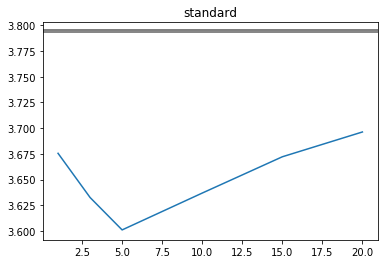

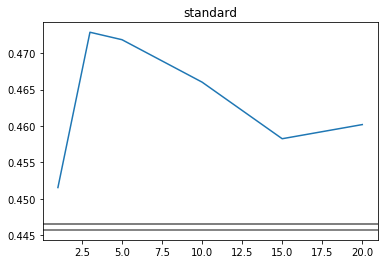

In [4]:
def sweep(data, mode, feature):
    num_ligs = sorted(set(k[0] for k in data[mode].keys()))
    alpha_factor = 2.0
    performances = []
    for n in num_ligs:
        performances += [performance(data[mode][(n, alpha_factor, feature)])]
    plt.plot(num_ligs, [p[2] for p in performances])
    for p in performances:
        plt.axhline(p[0], c = 'grey')
    plt.title(mode)
    plt.show()
    
    plt.plot(num_ligs, [p[3] for p in performances])
    for p in performances:
        plt.axhline(p[1], c = 'grey')
    plt.title(mode)
    plt.show()

sweep(data, 'standard', 'mcss_contact_hbond_sb')

In [5]:
def drug_average(n):
    families = {
        'GPCR': ['5HT2B', 'A2AR', 'B1AR', 'B2AR', 'CHRM3','SMO', 'MGLUR5'],
        'Kinase': ['BRAF', 'CDK2', 'CHK1', 'JAK2', 'PLK1', 'MAPK14', 'MEK1'],
        #'Ion Channel': ['TRPV1'],
        'Transporter': ['SLC6A4', 'GLUT1', 'DAT'],
        'Nuclear Receptor': ['NR3C2', 'NR3C1', 'AR', 'VDR', 'ERA'],
        'Peptidase': ['F2', 'F10', 'F11', 'PLAU', 'P00760', 'BACE1'],
        'Other': ['PYGM', 'PTPN1', 'BRD4', 'HSP90AA1', 'PDE10A', 'SIGMAR1', 'ELANE', 'TRPV1']
    }
    targets = {'GPCR': 0.33,
               'Kinase': 0.03,
               #'Ion Channel': 0.18,
               'Nuclear Receptor': 0.16,
               'Other': 0.20+0.18,
               'Peptidase': 0.03,
               'Transporter': 0.07}

    g_t, c_t, b_t = 0, 0, 0
    for family, members in families.items():
        glide, combind, best = ligand_level_performance(data['standard'][(n, 1.0, 'mcss_contact_hbond_sb')], members, correct_only = True)
        glide, combind, best = np.mean(np.array(glide) < 2.0), np.mean(np.array(combind) < 2.0), np.mean(np.array(best) < 2.0)
        print(family, targets[family], glide, combind, best)
        
        g_t += targets[family] * glide
        c_t += targets[family] * combind
        b_t += targets[family] * best
    print(g_t, c_t, b_t)
      
for n in [10]:
    print(n)
    drug_average(n)

10
GPCR 0.33 0.375 0.5 1.0
Kinase 0.03 0.7340425531914894 0.6170212765957447 1.0
Transporter 0.07 0.5 0.6666666666666666 1.0
Nuclear Receptor 0.16 0.896551724137931 0.8620689655172413 1.0
Peptidase 0.03 0.5428571428571428 0.5571428571428572 1.0
Other 0.38 0.5454545454545454 0.6753246753246753 1.0
0.5477779940162552 0.6414460017849599 1.0


In [6]:
print((0.48203861147015037 - 0.40942238707989015) / (0.7585791427840918 - 0.40942238707989015))

0.20797599703835942


In [7]:
print(0.4166666666666667 / 0.3125)
print(0.5714285714285714 / 0.42857142857142855)
print(0.4727272727272727 / 0.38181818181818183)

1.3333333333333335
1.3333333333333333
1.238095238095238


364 valid ligands
Ttest_relResult(statistic=0.010204585166924284, pvalue=0.9918636662022271)
ComBind improves pose for 54 of 364 ligands
ComBind degrades pose for 52 of 364 ligands
All Ligands RMSD Glide: 2.351021988644748, 0.6318681318681318
All Ligands RMSD ComBind: 2.349939232623349, 0.6428571428571429


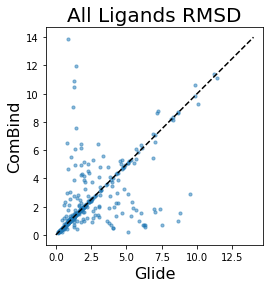

Mean RMSD Glide: 2.528692162573133
Mean RMSD ComBind: 2.559899857777177


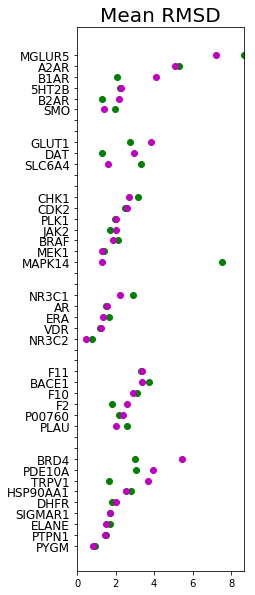

Fraction Near-Native Glide: 0.5865415008442614
Fraction Near-Native ComBind: 0.6055513020070555


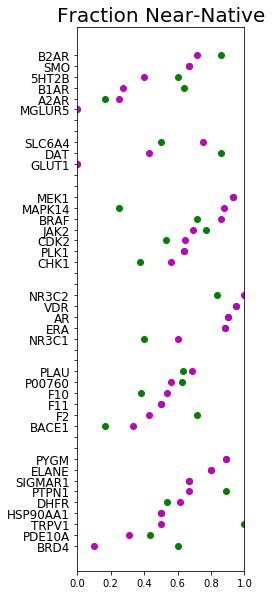

In [8]:
benchmark(data['standard'][(10, 1.0, 'mcss_contact_hbond_sb')], correct_only=True)

364 valid ligands
Ttest_relResult(statistic=0.8715260212066296, pvalue=0.3840430426357815)
ComBind improves pose for 40 of 364 ligands
ComBind degrades pose for 35 of 364 ligands
All Ligands RMSD Glide: 2.351021988644748, 0.6318681318681318
All Ligands RMSD ComBind: 2.275638185164794, 0.6593406593406593


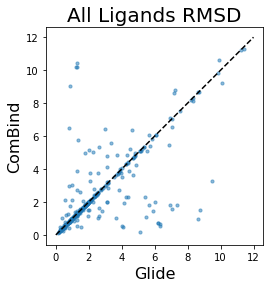

Mean RMSD Glide: 2.528692162573133
Mean RMSD ComBind: 2.498586116406384


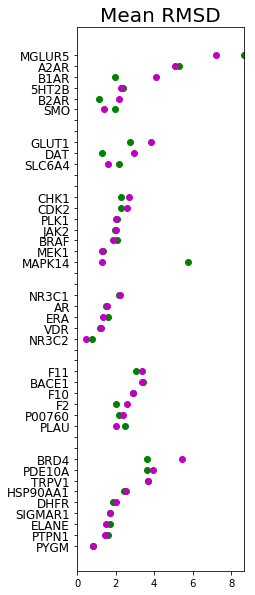

Fraction Near-Native Glide: 0.5865415008442614
Fraction Near-Native ComBind: 0.6113554470268867


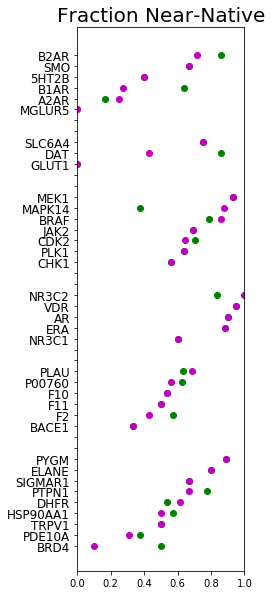

In [9]:
benchmark(data['standard'][(10, 2.0, 'mcss_contact_hbond_sb')], correct_only = True)

515 valid ligands
Ttest_relResult(statistic=1.2927249949501853, pvalue=0.19668697224756845)
ComBind improves pose for 88 of 515 ligands
ComBind degrades pose for 67 of 515 ligands
All Ligands RMSD Glide: 3.795146189155737, 0.44660194174757284
All Ligands RMSD ComBind: 3.6886583856914283, 0.45436893203883494


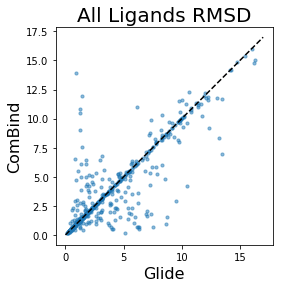

Mean RMSD Glide: 3.734684246014606
Mean RMSD ComBind: 3.541180412288421


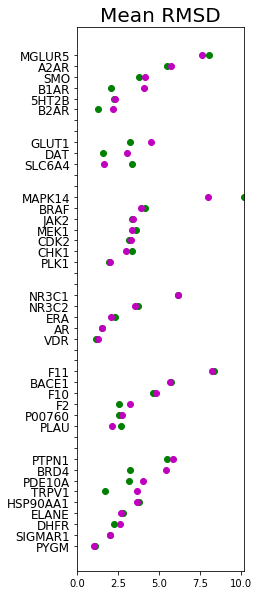

Fraction Near-Native Glide: 0.439621986129339
Fraction Near-Native ComBind: 0.4698638008687028


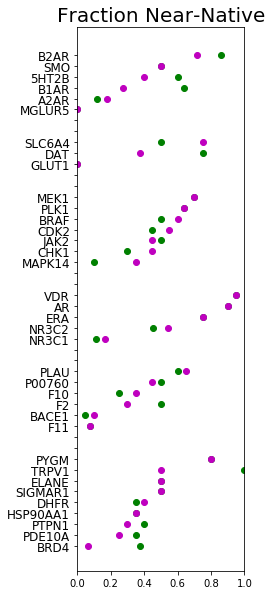

In [10]:
benchmark(data['standard'][(10, 1.0, 'mcss_contact_hbond_sb')], correct_only = False)

515 valid ligands
Ttest_relResult(statistic=2.2893623263778977, pvalue=0.022462856939130752)
ComBind improves pose for 71 of 515 ligands
ComBind degrades pose for 47 of 515 ligands
All Ligands RMSD Glide: 3.7951461891557368, 0.44660194174757284
All Ligands RMSD ComBind: 3.6368529709816917, 0.46601941747572817


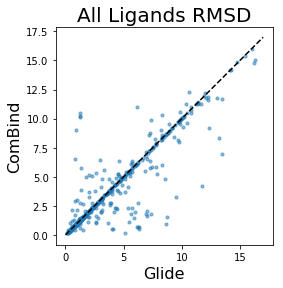

Mean RMSD Glide: 3.734684246014607
Mean RMSD ComBind: 3.532227519159745


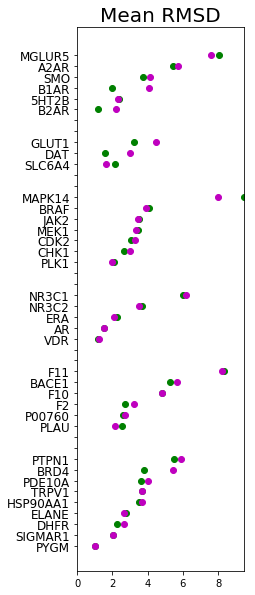

Fraction Near-Native Glide: 0.439621986129339
Fraction Near-Native ComBind: 0.46689312185635706


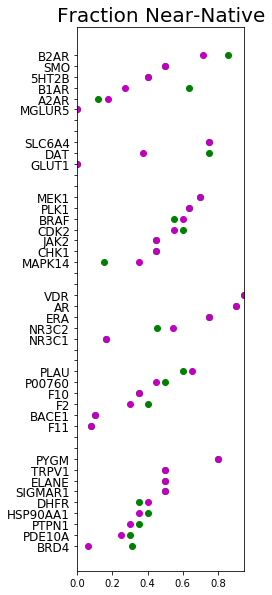

In [11]:
benchmark(data['standard'][(10, 2.0, 'mcss_contact_hbond_sb')], correct_only = False)

358 valid ligands
Ttest_relResult(statistic=-0.3333524802764144, pvalue=0.7390639246492836)
ComBind improves pose for 49 of 358 ligands
ComBind degrades pose for 52 of 358 ligands
All Ligands RMSD Glide: 2.3536880079868503, 0.6340782122905028
All Ligands RMSD ComBind: 2.391464060186685, 0.6340782122905028


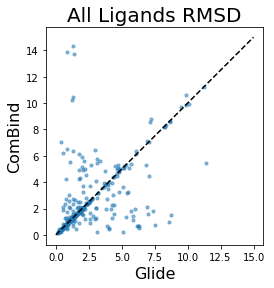

Mean RMSD Glide: 2.5297856116667266
Mean RMSD ComBind: 2.618143659944988


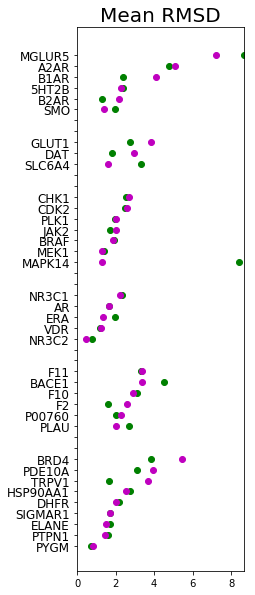

Fraction Near-Native Glide: 0.5882846265457204
Fraction Near-Native ComBind: 0.5906485135426055


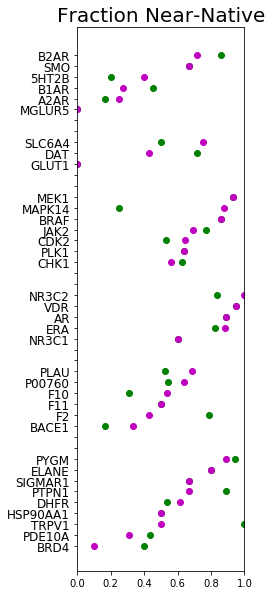

In [12]:
benchmark(data['standard'][(5, 1.0, 'mcss_contact_hbond_sb')], correct_only = True)

142 valid ligands
Ttest_relResult(statistic=2.387371699711401, pvalue=0.01829530134855965)
ComBind improves pose for 29 of 142 ligands
ComBind degrades pose for 20 of 142 ligands
All Ligands RMSD Glide: 2.889802516103728, 0.5
All Ligands RMSD ComBind: 2.5265586592280633, 0.5774647887323944


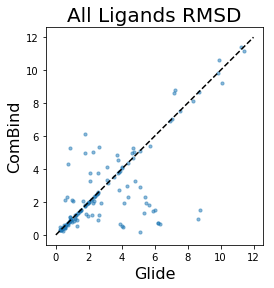

Mean RMSD Glide: 2.9914241970437705
Mean RMSD ComBind: 2.6559020619686615


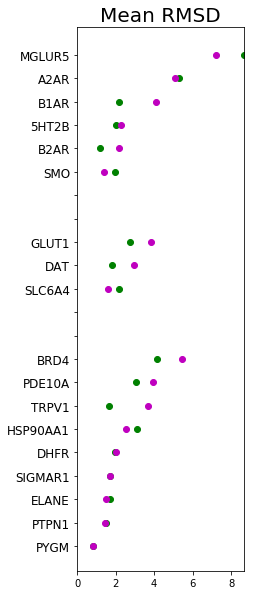

Fraction Near-Native Glide: 0.4740198844365511
Fraction Near-Native ComBind: 0.5706817102650436


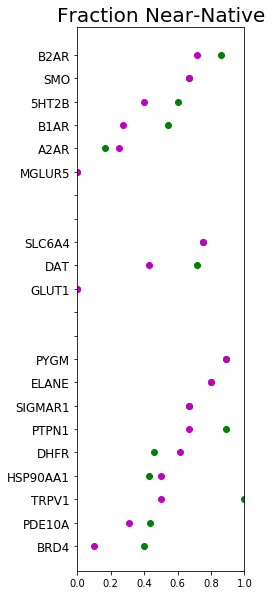

In [13]:
benchmark(data['standard'][(20, 1.0, 'mcss_contact_hbond_sb')],
          families = ['GPCR', 'Transporter', 'Other'],
          correct_only = True)

192 valid ligands
Ttest_relResult(statistic=4.087873043583641, pvalue=6.407862042872956e-05)
ComBind improves pose for 52 of 192 ligands
ComBind degrades pose for 24 of 192 ligands
All Ligands RMSD Glide: 3.7686735218498195, 0.3697916666666667
All Ligands RMSD ComBind: 3.2019246298948887, 0.453125


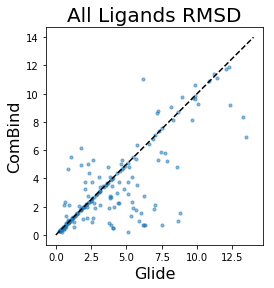

Mean RMSD Glide: 3.6754016439562087
Mean RMSD ComBind: 3.1331016278258934


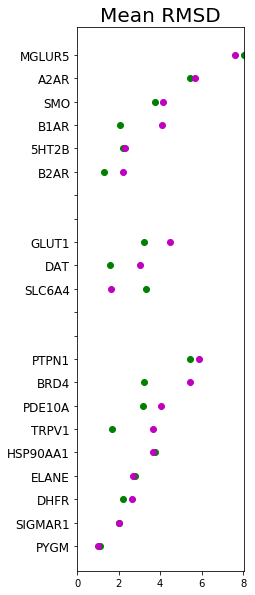

Fraction Near-Native Glide: 0.3806101986249045
Fraction Near-Native ComBind: 0.47700853068500126


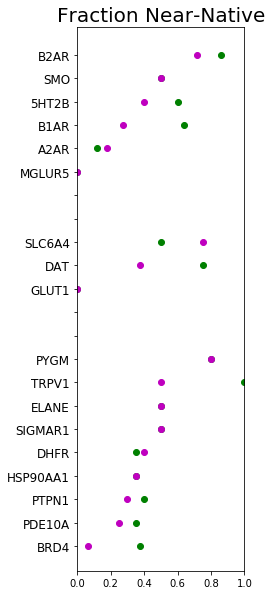

In [14]:
benchmark(data['standard'][(10, 1.0, 'mcss_contact_hbond_sb')],
          families = ['GPCR', 'Transporter', 'Other'])

131 valid ligands
Ttest_relResult(statistic=-2.037347901299599, pvalue=0.043644683296304734)
ComBind improves pose for 12 of 131 ligands
ComBind degrades pose for 21 of 131 ligands
All Ligands RMSD Glide: 3.9800432177030927, 0.5267175572519084
All Ligands RMSD ComBind: 4.409231038656359, 0.44274809160305345


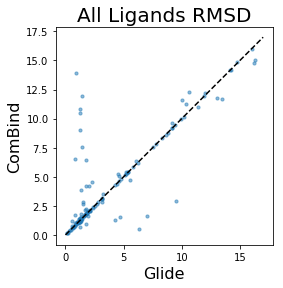

Mean RMSD Glide: 3.853178718436975
Mean RMSD ComBind: 4.251147962701402


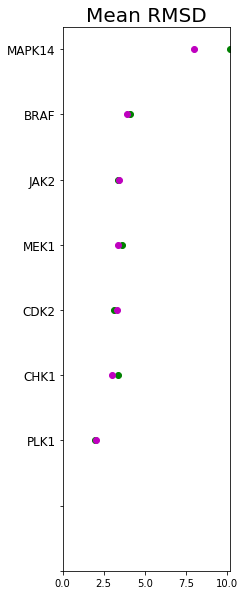

Fraction Near-Native Glide: 0.5337662337662338
Fraction Near-Native ComBind: 0.4551948051948052


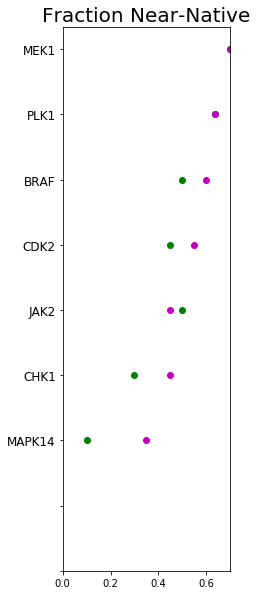

In [15]:
benchmark(data['standard'][(10, 1.0, 'mcss_contact_hbond_sb')],
          families = ['Kinase'])

48 valid ligands
Ttest_relResult(statistic=2.5176339312504923, pvalue=0.015281314586264087)
ComBind improves pose for 13 of 48 ligands
ComBind degrades pose for 7 of 48 ligands
All Ligands RMSD Glide: 4.490167492815709, 0.3125
All Ligands RMSD ComBind: 3.806342256148709, 0.4166666666666667


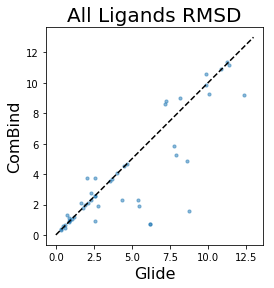

Mean RMSD Glide: 4.332481409113982
Mean RMSD ComBind: 3.805595048171469


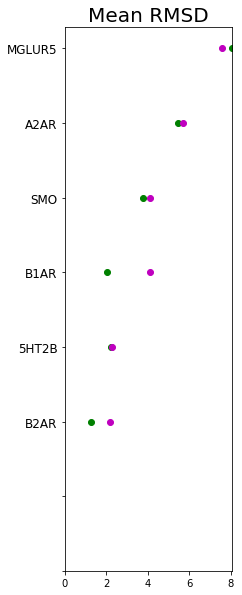

Fraction Near-Native Glide: 0.34391392920804686
Fraction Near-Native ComBind: 0.45185892538833716


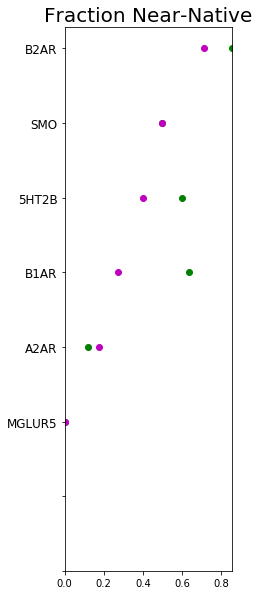

In [16]:
benchmark(data['standard'][(10, 1.0, 'mcss_contact_hbond_sb')],
          families = ['GPCR'])

130 valid ligands
Ttest_relResult(statistic=3.1855062448296323, pvalue=0.0018122941513778383)
ComBind improves pose for 34 of 130 ligands
ComBind degrades pose for 15 of 130 ligands
All Ligands RMSD Glide: 3.603211023523687, 0.38461538461538464
All Ligands RMSD ComBind: 3.074738013111736, 0.45384615384615384


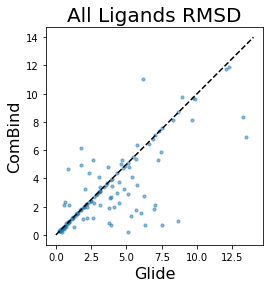

Mean RMSD Glide: 3.447474816012374
Mean RMSD ComBind: 2.825208665317489


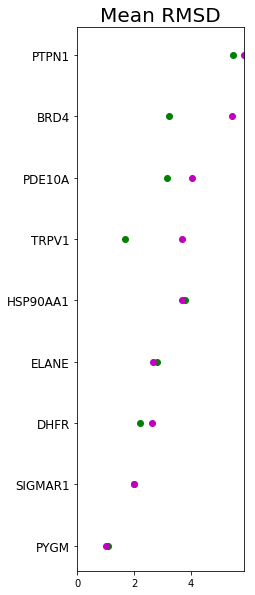

Fraction Near-Native Glide: 0.4069444444444444
Fraction Near-Native ComBind: 0.5138888888888888


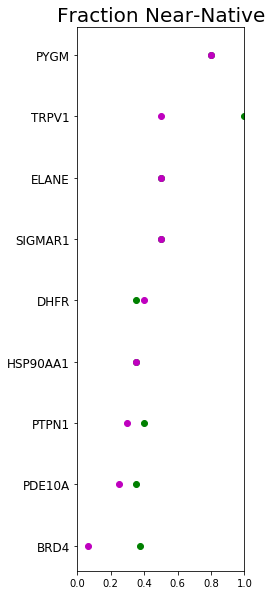

In [17]:
benchmark(data['standard'][(10, 1.0, 'mcss_contact_hbond_sb')],
          families = ['Other'])

113 valid ligands
Ttest_relResult(statistic=0.5135293508501634, pvalue=0.6085926622699189)
ComBind improves pose for 19 of 113 ligands
ComBind degrades pose for 16 of 113 ligands
All Ligands RMSD Glide: 4.230906936664662, 0.336283185840708
All Ligands RMSD ComBind: 4.166202736217937, 0.34513274336283184


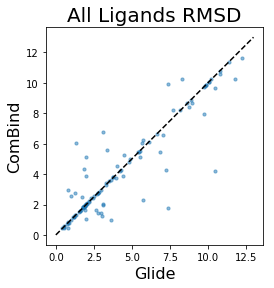

Mean RMSD Glide: 4.463948332651962
Mean RMSD ComBind: 4.410197440562879


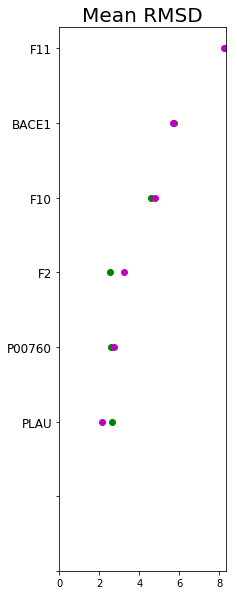

Fraction Near-Native Glide: 0.3211538461538461
Fraction Near-Native ComBind: 0.3294871794871795


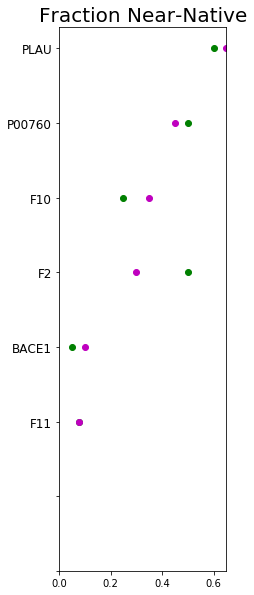

In [18]:
benchmark(data['standard'][(10, 1.0, 'mcss_contact_hbond_sb')],
          families = ['Peptidase'])

14 valid ligands
Ttest_relResult(statistic=0.8057522346522743, pvalue=0.4348773298582145)
ComBind improves pose for 5 of 14 ligands
ComBind degrades pose for 2 of 14 ligands
All Ligands RMSD Glide: 2.831417391566572, 0.42857142857142855
All Ligands RMSD ComBind: 2.3106542100110716, 0.5714285714285714


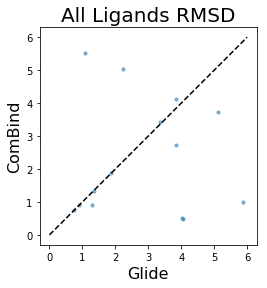

Mean RMSD Glide: 3.0450225974721667
Mean RMSD ComBind: 2.7117936746599582


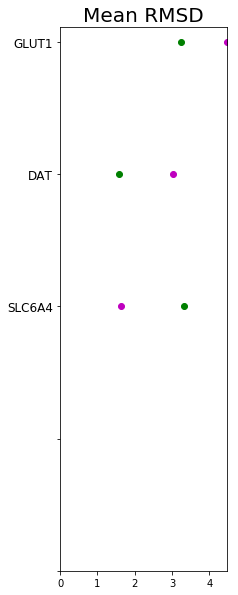

Fraction Near-Native Glide: 0.375
Fraction Near-Native ComBind: 0.4166666666666667


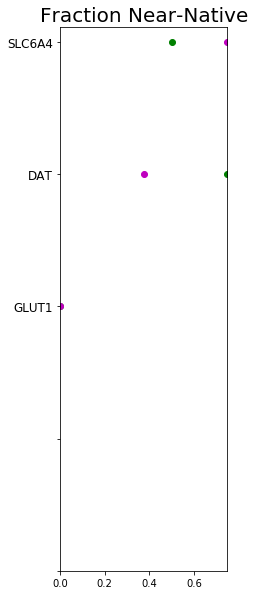

In [19]:
benchmark(data['standard'][(10, 1.0, 'mcss_contact_hbond_sb')],
          families = ['Transporter'])